In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gc
from pathlib import Path


from sklearn.metrics import accuracy_score
from IPython.display import FileLink

In [3]:
!pip freeze | grep -e fastai -e torch

fastai==1.0.50.post1
torch==1.0.1.post2
torchaudio==0.2
torchtext==0.3.1
torchvision==0.2.2


In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import *
import pretrainedmodels

In [5]:
DATA_DIR = Path('../input')

In [6]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [7]:
label_mapper = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

In [8]:
train_df['label'] = train_df['label'].map(label_mapper)

In [9]:
train_df.head()

,image_name,label,valid
0,7238.jpg,forest,False
1,1532.jpg,forest,False
2,23230.jpg,glacier,False
3,19137.jpg,mountain,False
4,22805.jpg,forest,False


In [10]:
train_il = ImageList.from_df(df=train_df, cols='image_name', path=DATA_DIR/'images/images')
test_il = ImageList.from_df(df=test_df, cols='image_name', path=DATA_DIR/'images/images')

In [11]:
np.random.seed(0)
src1 = (train_il
        .split_from_df(col='valid')
        .label_from_df(cols='label')
        .add_test(test_il))

In [14]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,3), length=(10, 20), p=.5)])
data1 = (src1
        .transform(tfms, size=150)
        .databunch(path='.', bs=128, num_workers=0)
        .normalize(imagenet_stats)
        )

In [15]:
data1

ImageDataBunch;

Train: LabelList (13627 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
forest,forest,glacier,mountain,forest
Path: ../input/images/images;

Valid: LabelList (3407 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
street,glacier,buildings,buildings,sea
Path: ../input/images/images;

Test: LabelList (7301 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: EmptyLabelList
,,,,
Path: ../input/images/images

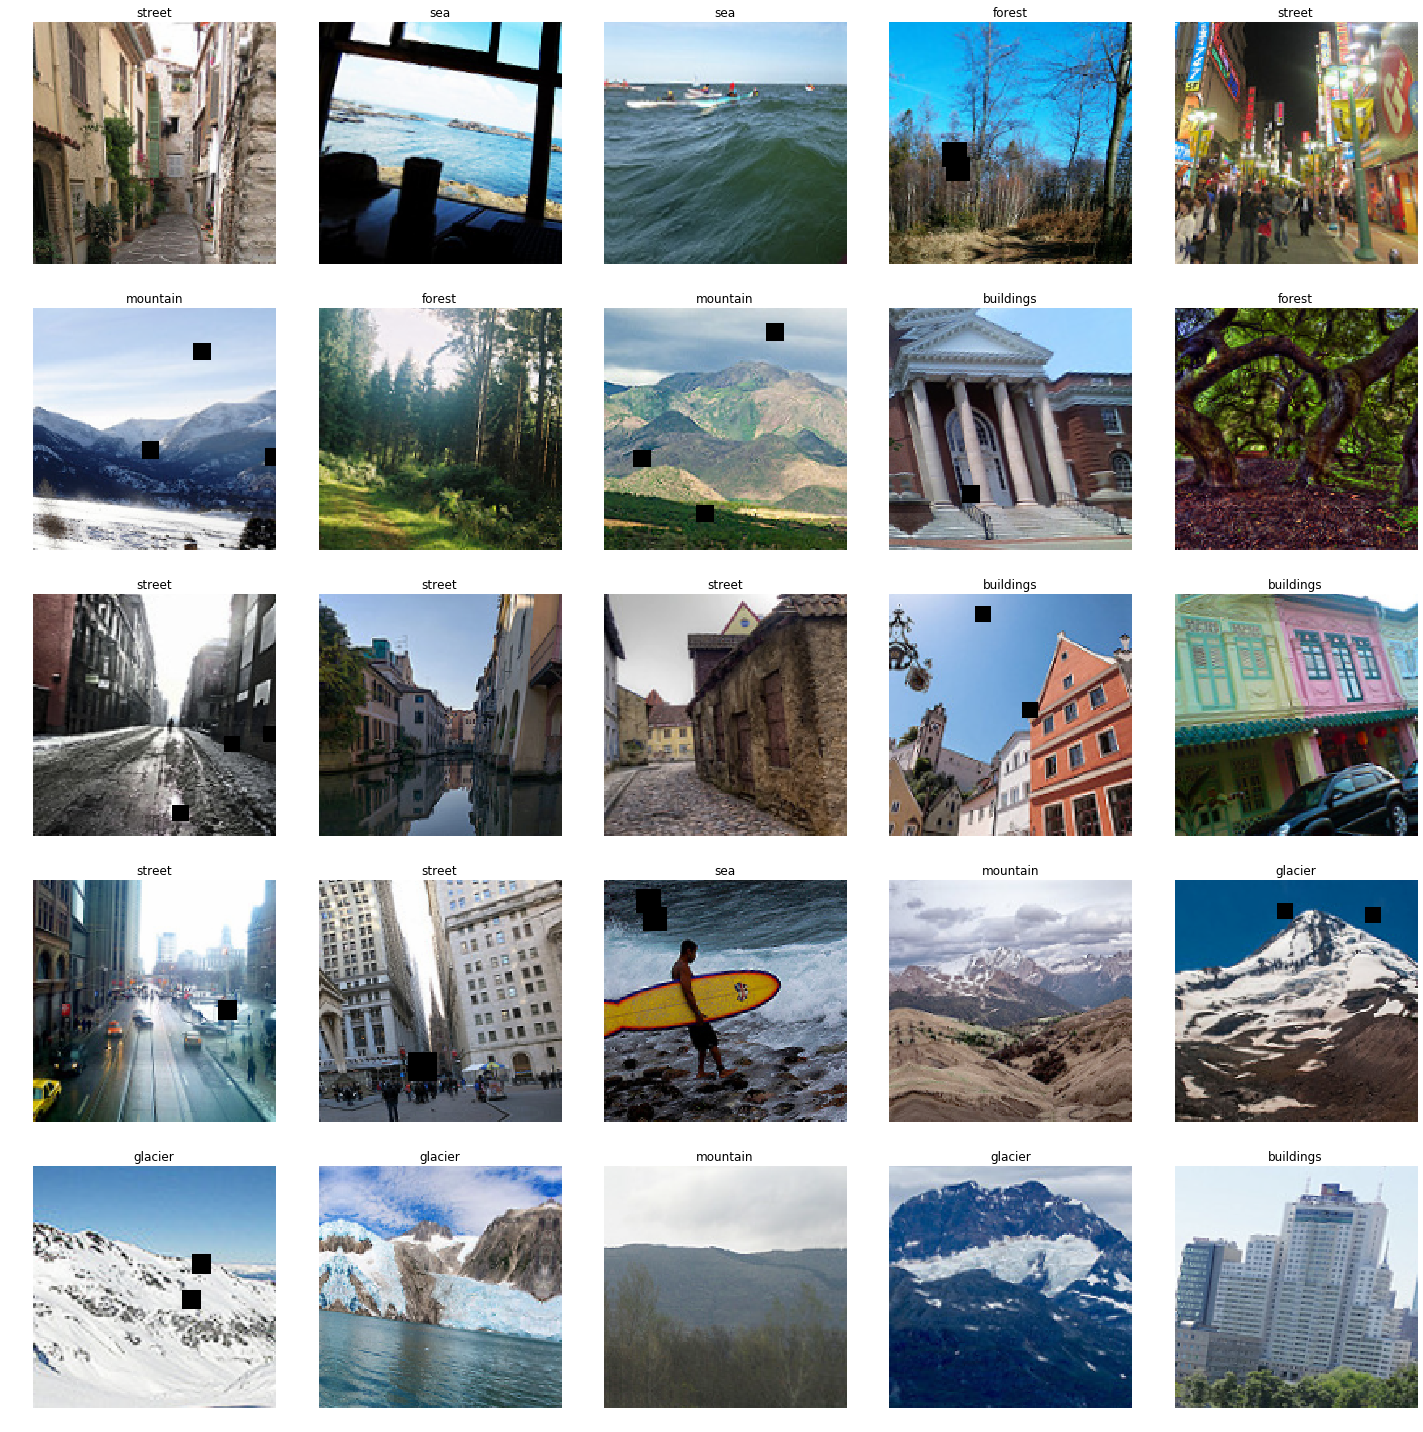

In [16]:
data1.show_batch()

In [17]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [23]:
def model_f(pretrained=True, **kwargs):
    return pretrainedmodels.__dict__['se_resnext101_32x4d'](num_classes=1000, pretrained='imagenet')

def getLearner(data):
    learn1 = cnn_learner(data, model_f, metrics=[accuracy])
    return learn1

In [24]:
learn1 = getLearner(data1)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /tmp/.torch/models/se_resnext101_32x4d-3b2fe3d8.pth
196466866it [00:08, 24545547.24it/s]


In [26]:
len(learn1.layer_groups)

2

In [27]:
learn1.wd

0.01

In [28]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


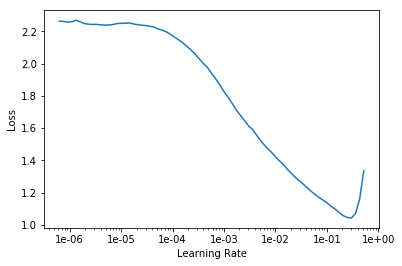

In [29]:
learn1.recorder.plot()

In [30]:
se_rnxt101_stage1_callbacks = [CSVLogger(learn=learn1, filename='se_rnxt101-stage1-history'), ShowGraph(learn=learn1)]

epoch,train_loss,valid_loss,accuracy,time
0,0.455370,0.331290,0.886410,02:57
1,0.357932,0.253766,0.907250,02:42
2,0.285585,0.245315,0.913414,02:41
3,0.231877,0.216752,0.925741,02:45
4,0.198005,0.212027,0.926328,02:44


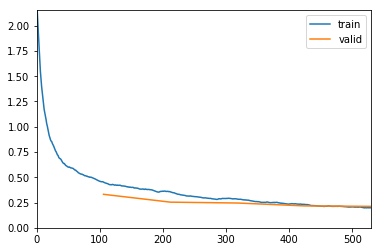

In [31]:
lr = 1e-2
learn1.fit_one_cycle(5, slice(lr), callbacks=se_rnxt101_stage1_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.455370	0.331290	0.886410	02:57
1	0.357932	0.253766	0.907250	02:42
2	0.285585	0.245315	0.913414	02:41
3	0.231877	0.216752	0.925741	02:45
4	0.198005	0.212027	0.926328	02:44
</pre>

In [32]:
learn1.save('stage1')

In [33]:
learn1.unfreeze()

In [34]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


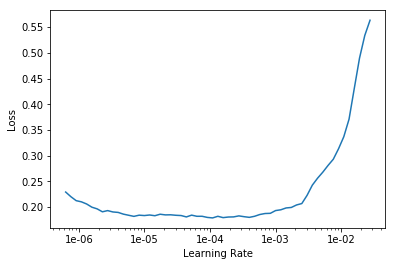

In [36]:
learn1.recorder.plot()

In [ ]:
# rn101_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn101-stage2-history'), EarlyStoppingCallback(learn=learn1, monitor='accuracy', min_delta=0.005, patience=8), SaveModelCallback(learn=learn1, monitor='accuracy', name='rn101-stage2'), ShowGraph(learn=learn1)]     

In [37]:
se_rnxt101_stage2_callbacks = [CSVLogger(learn=learn1, filename='se_rnxt101-stage2-history'), ShowGraph(learn=learn1)]

epoch,train_loss,valid_loss,accuracy,time
0,0.186770,0.196567,0.932492,03:09
1,0.165138,0.187107,0.935134,03:08
2,0.137704,0.203709,0.934547,03:08
3,0.101794,0.213162,0.935134,03:08
4,0.072980,0.213531,0.934547,03:08
5,0.048574,0.229437,0.932198,03:07
6,0.030983,0.240239,0.939830,03:07
7,0.019466,0.249801,0.942471,03:09
8,0.013691,0.239436,0.941884,03:08
9,0.011279,0.240000,0.943352,03:08


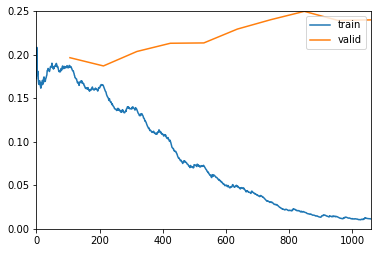

In [39]:
learn1.fit_one_cycle(10, slice(1e-4, lr/5), callbacks=se_rnxt101_stage2_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.186770	0.196567	0.932492	03:09
1	0.165138	0.187107	0.935134	03:08
2	0.137704	0.203709	0.934547	03:08
3	0.101794	0.213162	0.935134	03:08
4	0.072980	0.213531	0.934547	03:08
5	0.048574	0.229437	0.932198	03:07
6	0.030983	0.240239	0.939830	03:07
7	0.019466	0.249801	0.942471	03:09
8	0.013691	0.239436	0.941884	03:08
9	0.011279	0.240000	0.943352	03:08
</pre>

In [40]:
learn1.save('rn50-places-stage2')

In [41]:
from fastai.callbacks.hooks import *
import cv2
import matplotlib.pyplot as plt
import random

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index, learner, imgDataBunch):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, learner, imgDataBunch, classes=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = random.randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

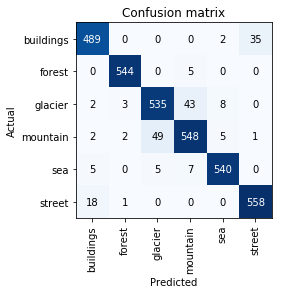

In [42]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix(title='Confusion matrix')

Almost all the problem is with mountain and glacier, street and building.

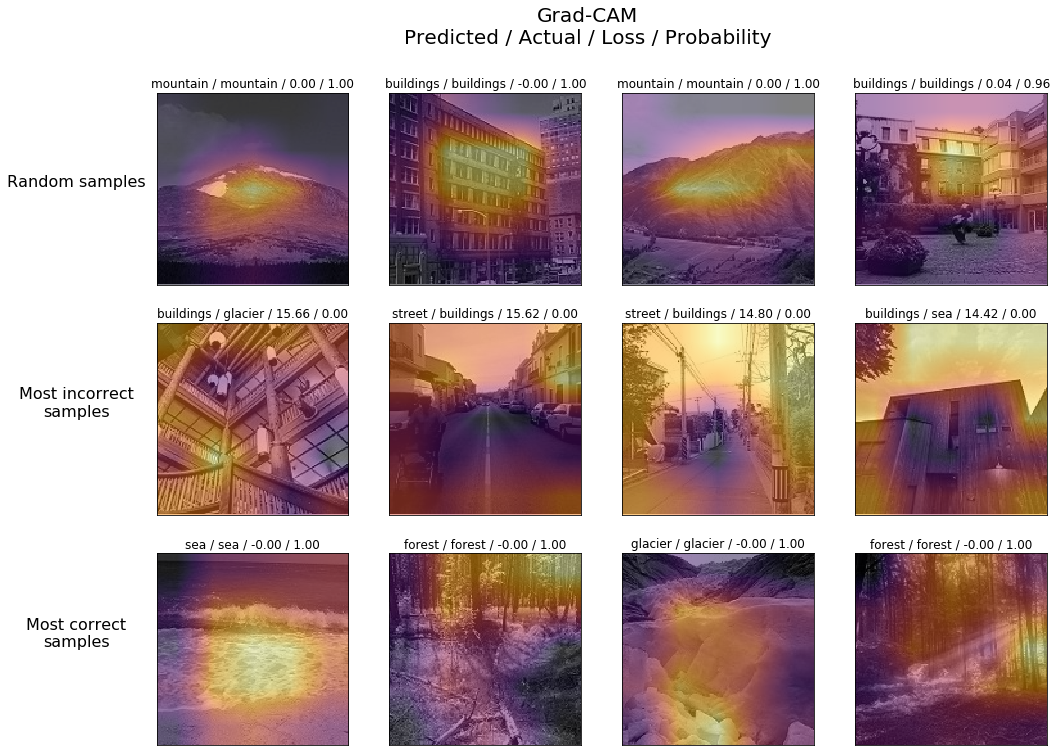

In [43]:
plot_heatmap_overview(interp, learn1, data1)

In [44]:
val_preds_tta = learn1.TTA(ds_type=DatasetType.Valid)

In [45]:
accuracy_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy())

0.9506897563839155

In [46]:
val_preds = learn1.get_preds()

In [47]:
accuracy_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy())

0.9433519225124744

In [48]:
val_img_names = [Path(i).name for i in learn1.data.valid_ds.x.items]

In [49]:
val_probs_tta_df = pd.DataFrame(val_preds_tta[0].numpy(), columns=learn1.data.train_ds.classes)
val_probs_tta_df['image_name'] = val_img_names
val_probs_tta_df['ground_label'] = val_preds_tta[1].numpy()

In [50]:
val_probs_df = pd.DataFrame(val_preds[0].numpy(), columns=learn1.data.train_ds.classes)
val_probs_df['image_name'] = val_img_names
val_probs_df['ground_label'] = val_preds[1].numpy()

In [51]:
test_preds_tta = learn1.TTA(ds_type=DatasetType.Test)

In [52]:
test_preds = learn1.get_preds(ds_type=DatasetType.Test)

In [61]:
test_img_names = [Path(i).name for i in learn1.data.test_ds.x.items]

In [62]:
test_probs_tta_df = pd.DataFrame(test_preds_tta[0].numpy(), columns=learn1.data.train_ds.classes)
test_probs_tta_df['image_name'] = test_img_names

In [63]:
test_probs_df = pd.DataFrame(test_preds[0].numpy(), columns=learn1.data.train_ds.classes)
test_probs_df['image_name'] = test_img_names

In [64]:
test_pred_tta_df = pd.DataFrame({'image_name': test_img_names})
test_pred_tta_df['label'] = test_preds_tta[0].argmax(1).numpy()

In [65]:
test_pred_df = pd.DataFrame({'image_name': test_img_names})
test_pred_df['label'] = test_preds[0].argmax(1).numpy()

In [66]:
val_probs_tta_df.to_csv('val_probs_tta.csv', index=False)
val_probs_df.to_csv('val_probs.csv', index=False)
test_probs_tta_df.to_csv('test_probs_tta.csv', index=False)
test_probs_df.to_csv('test_probs.csv', index=False)
test_pred_tta_df.to_csv('test_pred_tta.csv', index=False)
test_pred_df.to_csv('test_pred.csv', index=False)

In [67]:
!ls

__notebook_source__.ipynb      test_pred.csv	   val_probs.csv
models			       test_pred_tta.csv   val_probs_tta.csv
se_rnxt101-stage1-history.csv  test_probs.csv
se_rnxt101-stage2-history.csv  test_probs_tta.csv


In [68]:
!ls -lh models

total 956M
-rw-r--r-- 1 root root 562M Mar 31 17:10 rn50-places-stage2.pth
-rw-r--r-- 1 root root 205M Mar 31 16:31 stage1.pth
-rw-r--r-- 1 root root 188M Mar 31 16:31 tmp.pth


In [69]:
FileLink('val_probs_tta.csv')

/kaggle/working/val_probs_tta.csv

In [70]:
FileLink('val_probs.csv')

/kaggle/working/val_probs.csv

In [71]:
FileLink('test_probs_tta.csv')

/kaggle/working/test_probs_tta.csv

In [72]:
FileLink('test_probs.csv')

/kaggle/working/test_probs.csv

In [73]:
FileLink('test_pred_tta.csv')

/kaggle/working/test_pred_tta.csv

In [74]:
FileLink('test_pred.csv')

/kaggle/working/test_pred.csv

In [76]:
FileLink('se_rnxt101-stage1-history.csv')

/kaggle/working/se_rnxt101-stage1-history.csv

In [77]:
FileLink('se_rnxt101-stage2-history.csv')

/kaggle/working/se_rnxt101-stage2-history.csv